In [2]:
%load_ext autoreload
%autoreload 2

In [142]:
import os,sys, io
from collections import OrderedDict
from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.utils.rendertools import RenderTool
from PIL import Image
import networkx as nx
import json
from numpy import array
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from ipywidgets import Button, HBox, VBox
from flatland.utils.graph_utils import RailEnvGraph, trans_int_to_4x4, trans_int_to_binstr, trans_int_to_nesw, get_rail_transitions_df
from flatland.utils.graph_utils import get_simple_path, plotGraphEnv
import flatland.utils.graph_utils as gu
from flatland.envs.rail_generators import rail_from_manual_specifications_generator
from flatland.envs.rail_generators import random_rail_generator, complex_rail_generator, sparse_rail_generator, empty_rail_generator
from flatland.envs.observations import GlobalObsForRailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters
import ipywidgets as ipw

display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:

def RandomTestParams_small(tid):
    seed = tid * 19997 + 997
    random.seed(seed)

    nSize = random.randint(0,5)

    width = 20 + nSize * 5
    height = 20 + nSize * 5
    nr_cities = 2 + nSize // 2 + random.randint(0,2)
    nr_trains = min(nr_cities * 5, 5 + random.randint(0,5)) #, 10 + random.randint(0, 10))
    max_rails_between_cities = 2
    max_rails_in_cities = 3 + random.randint(0, nSize)
    
    malfunction_rate = 30 + random.randint(0, 100)
    malfunction_min_duration = 3 + random.randint(0, 7)
    malfunction_max_duration = 20 + random.randint(0, 80)
    return (
        seed, width, height, 
        nr_trains, nr_cities,
        max_rails_between_cities, max_rails_in_cities,
        malfunction_rate, malfunction_min_duration, malfunction_max_duration
        )


In [45]:

def create_test_env(fnParams, nTest, sDir):
    (seed, width, height,
    nr_trains, nr_cities, 
    max_rails_between_cities, max_rails_in_cities, 
    malfunction_rate, malfunction_min_duration, malfunction_max_duration) = fnParams(nTest)
    #if not ShouldRunTest(test_id):
    #    continue

    rail_generator = sparse_rail_generator(
        max_num_cities=nr_cities,
        seed=seed,
        grid_mode=False,
        max_rails_between_cities=max_rails_between_cities,
        max_rails_in_city=max_rails_in_cities,
    )


    

    stochastic_data = MalfunctionParameters(
                        malfunction_rate=malfunction_rate,
                        min_duration=malfunction_min_duration,
                        max_duration=malfunction_max_duration
    )


    observation_builder = GlobalObsForRailEnv()


    DEFAULT_SPEED_RATIO_MAP = {
        1.: 0.25,
        1. / 2.: 0.25,
        1. / 3.: 0.25,
        1. / 4.: 0.25}

    schedule_generator = sparse_schedule_generator(DEFAULT_SPEED_RATIO_MAP)

    for iAttempt in range(5):
        try:
            env = RailEnv(
                width=width,
                height=height,
                rail_generator=rail_generator,
                schedule_generator=schedule_generator,
                number_of_agents=nr_trains,
                malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
                obs_builder_object=observation_builder,
                remove_agents_at_target=True
                )
            obs = env.reset(random_seed = seed)
            break
        except ValueError as oErr:
            print("Error:", oErr)
            width += 5
            height += 5
            print("Try again with larger env: (w,h):", width, height)


    if not os.path.exists(sDir):
        os.makedirs(sDir)

    sfName = "{}/Level_{}.mpk".format(sDir, nTest)
    if os.path.exists(sfName):
        os.remove(sfName)
    env.save(sfName)

    #sys.stdout.write(".")
    #sys.stdout.flush()

    return env


In [7]:
tParams = RandomTestParams_small(1)

In [9]:
!mkdir tmp

/home/jeremy/projects/aicrowd/rl-trains/flatland/flatland/utils/rendertools.py:451: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


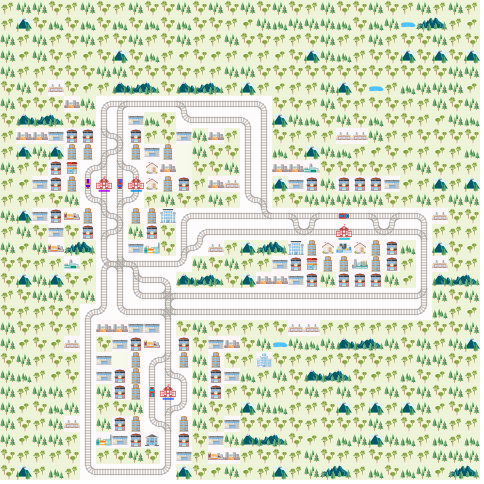

In [54]:
def envPic(nEnv):
    env = create_test_env(RandomTestParams_small, nEnv, "./tmp")
    oRT = RenderTool(env, gl="PILSVG")
    oRT.render_env()
    aImg = oRT.get_image()
    display(Image.fromarray(aImg))
    return env, aImg

env, aImg = envPic(1)


In [273]:
oReg = gu.RailEnvGraph(env)

In [274]:
#plotGraphEnv(G2, env, aImg)
plotGraphEnv(G2, env, aImg, figsize=(10,10), node_size=10,
                node_colors={"rail":"blue", "grid":"red"},
                edge_colors={"hold":"gray", "dir":"green"},
                show_nodes=("rail", "grid"),
                show_edges=("dir", "hold")
               )
with io.BytesIO() as fbio:
    plt.savefig(fbio, bbox_inches="tight", pad_inches=0)
    bimgEnv = fbio.getvalue()
plt.close()

In [275]:
G5 = oReg.reduce_simple_paths()

In [282]:
#plotGraphEnv(G2, env, aImg)
plotGraphEnv(G5, env, aImg, figsize=(10,10), node_size=10,
                space=0.1,
                node_colors={"rail":"blue", "grid":"red"},
                edge_colors={"hold":"gray", "dir":"green"},
                show_nodes=("rail", "grid"),
                show_edges=("dir"),
                show_labels=()
               )
with io.BytesIO() as fbOut:
    plt.savefig(fbOut, bbox_inches="tight", pad_inches=0)
    bimgReduced = fbOut.getvalue()
plt.close()

In [283]:
dlPos = {}
for agent in env.agents:
    l = dlPos.get(agent.initial_position, []) + [agent.handle]
    dlPos[agent.initial_position] = l

dlPos

{(13, 21): [0, 1, 6], (24, 9): [2, 7], (11, 5): [3], (11, 7): [4, 5]}

In [284]:
pilImg = Image.fromarray(aImg)

In [285]:
with io.BytesIO() as fOut:
    pilImg.save(fOut, format='PNG')
    byteImg = fOut.getvalue()

In [329]:
lwIm = [ ipw.Image(value=bim) for bim in [byteImg, bimgEnv, bimgReduced]]

In [330]:
(lGpaths, llnPaths, lltStartTarg) = gu.genStartTargetDirs(G5, env)
#lwImPath = []
for iAgent, Gpath in enumerate(lGpaths):
    plotGraphEnv(Gpath, env, aImg, figsize=(10,10), node_size=10,
                space=0.1,
                node_colors={"rail":"blue", "grid":"red"},
                edge_colors={"hold":"gray", "dir":"green"},
                show_nodes=("rail", "grid"),
                show_edges=("dir"),
                show_labels=(),
                show_edge_weights=True,
                alpha_img=0.7
               )
    with io.BytesIO() as fbOut:
        plt.savefig(fbOut, bbox_inches="tight", pad_inches=0)
        bimgPath = fbOut.getvalue()
    plt.close()
    lwIm.append(ipw.Image(value=bimgPath))
    
    
    

nAgents: 8


In [331]:
tab = ipw.Tab(lwIm)
tab.set_title(0, "map")
tab.set_title(1, "graph")
tab.set_title(2, "reduced graph")
for i in range(len(env.agents)):
    tab.set_title(3+i, f"path {i}")
tab

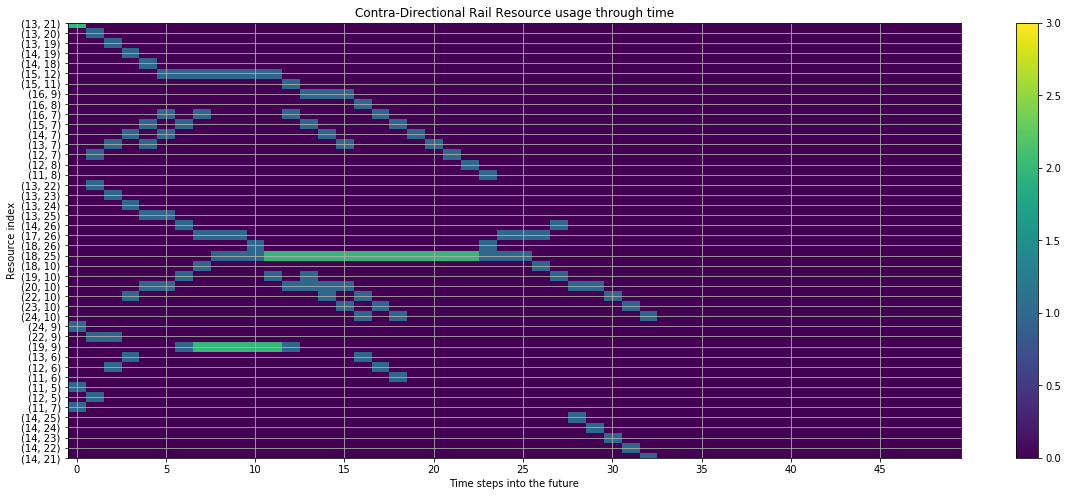

In [337]:
tDummy = gu.plotResourceUsage(G5, llnPaths, nSteps=50, nStepsShow=50, contradir=True, node_ticks=True)

In [382]:
tDummy[1]

OrderedDict([((13, 21), [(13, 21, 3), (13, 21, 1)]),
             ((13, 20), [(13, 20, 3)]),
             ((13, 19), [(13, 19, 3)]),
             ((14, 19), [(14, 19, 2)]),
             ((14, 18), [(14, 18, 3)]),
             ((15, 12), [(14, 17, 3)]),
             ((15, 11), [(15, 11, 3)]),
             ((16, 9), [(16, 11, 2)]),
             ((16, 8), [(16, 8, 3)]),
             ((16, 7), [(16, 7, 3), (16, 7, 0), (16, 7, 2)]),
             ((15, 7), [(15, 7, 0), (15, 7, 2)]),
             ((14, 7), [(14, 7, 0), (14, 7, 2)]),
             ((13, 7), [(13, 7, 0), (13, 7, 1), (13, 7, 2)]),
             ((12, 7), [(12, 7, 0), (12, 7, 2)]),
             ((12, 8), [(12, 8, 1)]),
             ((11, 8), [(11, 8, 0)]),
             ((13, 22), [(13, 22, 1)]),
             ((13, 23), [(13, 23, 1)]),
             ((13, 24), [(13, 24, 1)]),
             ((13, 25), [(13, 25, 1)]),
             ((14, 26), [(14, 26, 2), (14, 26, 0)]),
             ((17, 26), [(15, 26, 2), (17, 26, 0)]),
             (

In [338]:
lllnHammock = []
for nStart, nTarg in lltStartTarg:
    print(nStart, nTarg)
    llnHammock = gu.hammockPaths(G5, nStart, nTarg, endSkip=3, preamble=True)
    lllnHammock.append(llnHammock)

(13, 21, 3) (11, 8, 0)
(13, 21, 3) (11, 8, 0)
(13, 21, 3) (11, 8, 0)
(13, 21, 3) (11, 8, 0)
(13, 21, 3) (11, 8, 0)
(13, 21, 1) (24, 10, 2)
(13, 21, 1) (24, 10, 2)
(13, 21, 1) (24, 10, 2)
(13, 21, 1) (24, 10, 2)
(13, 21, 1) (24, 10, 2)
(24, 9, 0) (11, 6, 0)
(24, 9, 0) (11, 6, 0)
(24, 9, 0) (11, 6, 0)
(24, 9, 0) (11, 6, 0)
(11, 5, 2) (24, 10, 2)
(11, 5, 2) (24, 10, 2)
(11, 5, 2) (24, 10, 2)
(11, 5, 2) (24, 10, 2)
(11, 5, 2) (24, 10, 2)
(11, 7, 2) (24, 10, 2)
(11, 7, 2) (24, 10, 2)
(11, 7, 2) (24, 10, 2)
(11, 7, 2) (24, 10, 2)
(11, 7, 2) (24, 10, 2)
(11, 7, 2) (24, 10, 2)
(11, 7, 2) (24, 10, 2)
(11, 7, 2) (24, 10, 2)
(13, 21, 3) (11, 8, 0)
(13, 21, 3) (11, 8, 0)
(13, 21, 3) (11, 8, 0)
(13, 21, 3) (11, 8, 0)
(13, 21, 3) (11, 8, 0)
(24, 9, 0) (14, 21, 3)
(24, 9, 0) (14, 21, 3)
(24, 9, 0) (14, 21, 3)
(24, 9, 0) (14, 21, 3)


In [346]:
len(lllnHammock[0])

5

In [377]:
#G5c = nx.compose_all([ nx.induced_subgraph(G5, lnPath) for lnPath in lllnHammock[0][:1] + lllnHammock[1][1:2] ])
lwIm = []
for iAgent in range(len(env.agents)):
    G5c = nx.compose_all([ nx.induced_subgraph(G5, lnPath) for lnPath in lllnHammock[iAgent][:4] ])
    gu.plotGraphEnv(G5c, env, aImg, node_size=2, figsize=(10,10), alpha_img=0.7, space=0, show_edge_weights=True)
    with io.BytesIO() as fbOut:
        plt.savefig(fbOut, bbox_inches="tight", pad_inches=0)
        bimgPath = fbOut.getvalue()
    plt.close()
    lwIm.append(ipw.Image(value=bimgPath))

oTab = ipw.Tab(lwIm)

list(map(oTab.set_title, *zip(*[(i, str(i)) for i in range(len(lwIm)) ])))
oTab

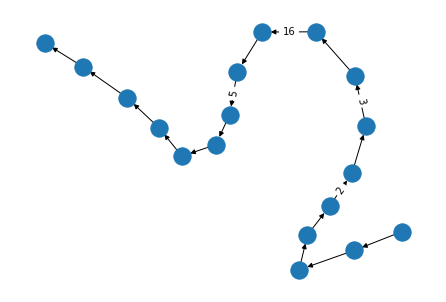

In [245]:
G=lGpaths[0]
pos = nx.spring_layout(G, scale=2)
nx.draw(G, pos)
labels = nx.get_edge_attributes(G,'l')
lab2 = { (uv[0], uv[1]):l for uv,l in labels.items() if l>1}

dummy=nx.draw_networkx_edge_labels(G, pos, edge_labels=lab2)


### Forcegraph

In [ ]:
oReg.savejson(filename="small-2d.json", alt_graph=G5, bKeepId=False)

In [76]:
%%html
<div id="d3-example"></div>
<script src="./d3_wrapper.js" id="graph2d" graph_file="./small-2d.json" width=1000 height=800 /></script>